In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time
import numpy as np

## ***Step 1:*** Load Data

Load the json files for train and validation, into lists of texts, queries, answers

In [ ]:
# Give the path for train data
path = Path('/content/drive/MyDrive/Colab Notebooks/NLP/data/train-v2.0.json')
#path = Path('train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            # Store context, queries and answers of incorrect questions with no answers
            if(qa['answers'] == []):
                texts.append(context)
                queries.append(question)
                answers.append({'text':'', 'answer_start':-1})
            else:
                for answer in qa['answers']:
                    # Store every passage, query and its answer to the lists
                    texts.append(context)
                    queries.append(question)
                    answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [ ]:
# Give the path for validation data
path = Path('/content/drive/MyDrive/Colab Notebooks/NLP/data/dev-v2.0.json')
#path = Path('dev-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []
num = 0

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        num += 1
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            # Store context, queries and answers of incorrect questions
            if(qa['answers'] == []):
                texts.append(context)
                queries.append(question)
                answers.append({'text':'', 'answer_start':-1})
            else:
                for answer in qa['answers']:
                    # Store every passage, query and its answer to the lists
                    texts.append(context)
                    queries.append(question)
                    answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

## ***Step 2:*** Understanding Data

In [ ]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))
print(len(np.unique(train_texts)))

130319
130319
130319
19029


As you can see we have 130319 rows with 19,029 unique passages

In [ ]:
# Sample data point in training data
print("Passage: ",train_texts[0])
print()
print("Query: ",train_queries[0])
print()
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

Query:  When did Beyonce start becoming popular?

Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
# Sample data point in validation data
print("Passage: ",val_texts[0])
print()
print("Query: ",val_queries[0])
print()
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.

Query:  In what country is Normandy located?

Answer:  {'text': 'France', 'answer_start': 159}


In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))
print(num)
print(len(np.unique(val_texts)))

13220
13220
13220
646
646


As you can see we have 13220 rows with 646 unique passages

In [ ]:
# Check the number of incorrect questions in the training data
ctr = 0
for i in train_answers:
  if len(i['text']) == 0:
    ctr += 1

print("Number of invalid questions: ", ctr)

Number of invalid questions:  43498


## ***Step 3:*** Data Preprocessing

Shorten the data to make it less computationally expensive

In [ ]:
train_texts = train_texts[:10000]
train_queries = train_queries[:10000]
train_answers = train_answers[:10000]

val_texts = val_texts[:5000]
val_queries = val_queries[:5000]
val_answers = val_answers[:5000]

In [ ]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

10000
10000
10000


In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

5000
5000
5000


Find end position character in train data

In [ ]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the end index
    end_idx = start_idx + len(real_answer)

Find end position character in validation data

In [ ]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the end index
    end_idx = start_idx + len(real_answer)

## ***Step 4:*** Tokenize queries and passages

Tokenizing using Bert based AutoTokenizer

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_queries, train_texts, truncation=True, padding = True, return_offsets_mapping=True, return_overflowing_tokens=True)
val_encodings = tokenizer(val_queries, val_texts, truncation=True, padding = True, return_offsets_mapping=True, return_overflowing_tokens=True)

## ***Step 5:*** Convert the start-end positions to start-end tokens

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  for i, offset in enumerate(encodings["offset_mapping"]):
      sample_idx = encodings["overflow_to_sample_mapping"][i]
      answer = answers[sample_idx]
      start_char = answer["answer_start"]
      end_char = answer["answer_start"] + len(answer["text"])
      sequence_ids = encodings.sequence_ids(i)

      # Find the start and end of the context
      idx = 0
      while sequence_ids[idx] != 1:
          idx += 1
      context_start = idx
      while sequence_ids[idx] == 1:
          idx += 1
      context_end = idx - 1

      # If the answer is not fully inside the context, label is (0, 0)
      if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
          start_positions.append(0)
          end_positions.append(0)
      else:
          # Otherwise it's the start and end token positions
          idx = context_start
          while idx <= context_end and offset[idx][0] <= start_char:
              idx += 1
          start_positions.append(idx - 1)

          idx = context_end
          while idx >= context_start and offset[idx][1] >= end_char:
              idx -= 1
          end_positions.append(idx + 1)

  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

Understanding the encodings:

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'start_positions', 'end_positions'])

In [ ]:
#Comparing original answer to decoded answer using start/end tokens
idx = 3000
sample_idx = train_encodings['overflow_to_sample_mapping'][idx]
answer = train_answers[sample_idx]['text']

start = train_encodings['start_positions'][idx]
end = train_encodings['end_positions'][idx]
labeled_answer = tokenizer.decode(train_encodings['input_ids'][idx][start:end+1])

print(answer,"---", labeled_answer)

2.3 metres --- 2. 3 metres


In [ ]:
# Decoding the encodings to view how the input looks
decoded_example = tokenizer.decode(train_encodings['input_ids'][idx])
print(decoded_example)

[CLS] what was the horizontal average slip on the guanxian - anxian fault? [SEP] the longmen shan fault system is situated in the eastern border of the tibetan plateau and contains several faults. this earthquake ruptured at least two imbricate structures in longmen shan fault system, i. e. the beichuan fault and the guanxian – anxian fault. in the epicentral area, the average slip in beichuan fault was about 3. 5 metres ( 11 ft ) vertical, 3. 5 metres ( 11 ft ) horizontal - parallel to the fault, and 4. 8 metres ( 16 ft ) horizontal - perpendicular to the fault. in the area about 30 kilometres ( 19 mi ) northeast of the epicenter, the surface slip on beichuan fault was almost purely dextral strike - slip up to about 3 metres ( 9. 8 ft ), while the average slip in guanxian – anxian fault was about 2 metres ( 6 ft 7 in ) vertical and 2. 3 metres ( 7 ft 7 in ) horizontal. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

## ***Step 6:*** Create a Dataset class

Create a SquadDataset class to pass input into the model.

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

Load data using DataLoader

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, worker_init_fn=np.random.seed(seed))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2, worker_init_fn=np.random.seed(seed))

## ***Step 7:*** Use GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

## ***Step 8:*** Load the Bert model

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=5e-6)
# optim = AdamW(model.parameters(), lr=5e-4)

# epochs = 2
epochs = 3
# epochs = 4

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
print(model)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
print(model.config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## ***Step 9:*** Train and Evaluate Model

In [ ]:
# Model Arguments: (Encodings, Attention Mask, Start token, End token)
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()

  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader):

    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):

    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 1252 
Loss: 1.9 

############Evaluate############

-------Epoch  1 -------
Training Loss: 2.9837419261661964 
Validation Loss: 2.3359945119809145 
Time:  1149.1964571475983 
----------------------- 


############Train############
Batch 1000 / 1252 
Loss: 2.7 

############Evaluate############

-------Epoch  2 -------
Training Loss: 1.6067465466622728 
Validation Loss: 2.227753055519446 
Time:  1148.8021550178528 
----------------------- 


############Train############
Batch 1000 / 1252 
Loss: 1.6 

############Evaluate############

-------Epoch  3 -------
Training Loss: 1.2346047011379617 
Validation Loss: 2.3190724554902067 
Time:  1148.4665215015411 
----------------------- 


Total training and evaluation time:  3446.4690778255463


In [ ]:
# Save model
torch.save(model,"/content/drive/MyDrive/Colab Notebooks/NLP/bertqa612")

## ***Step 12:*** Plot train and validation losses

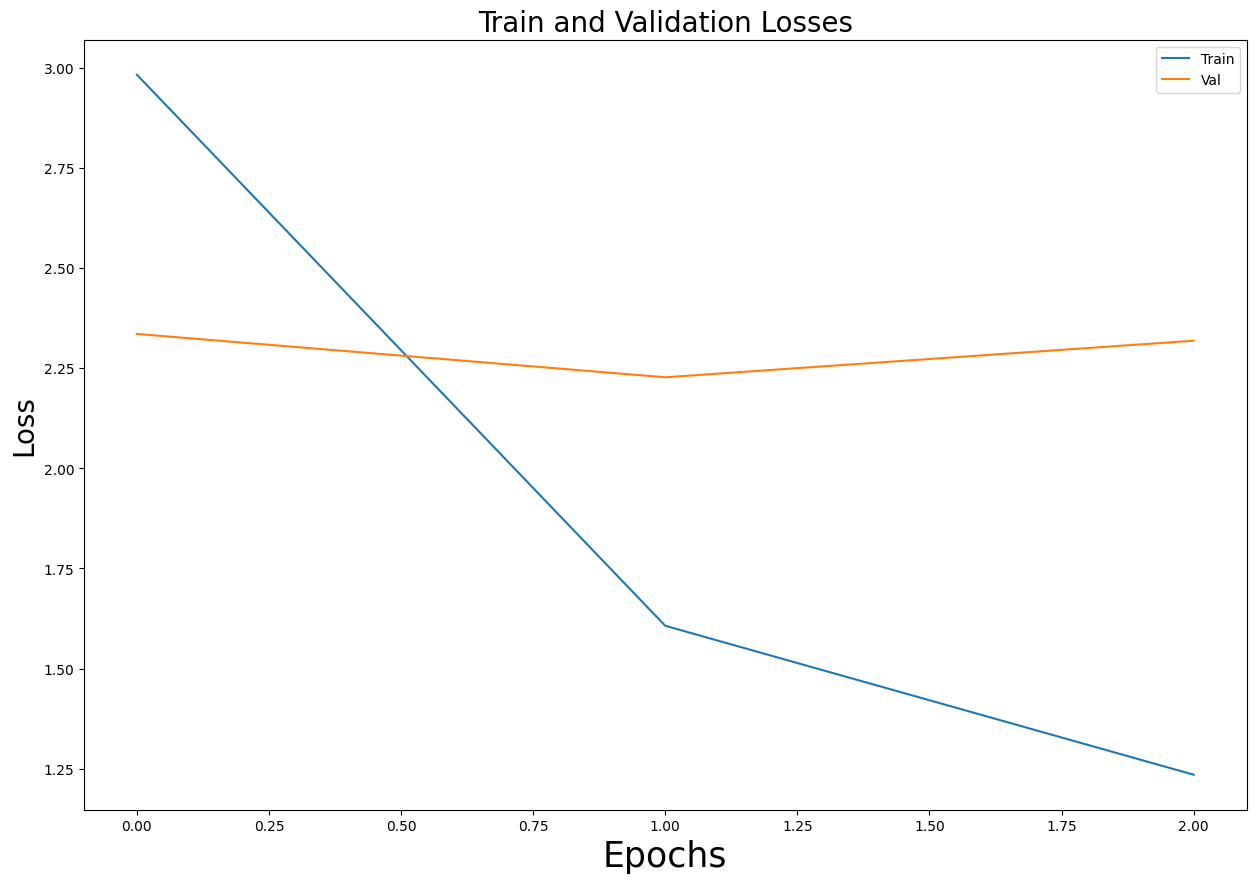

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

plt.savefig("/content/drive/MyDrive/Colab Notebooks/NLP/ft_qa6_10k")